# <img src="https://upload.wikimedia.org/wikipedia/commons/6/60/NISAR_artist_concept.jpg" width=400 align="left"/>
<img src="https://upload.wikimedia.org/wikipedia/commons/9/9b/NISAR_Mission_Logo.png" width=400 align="left"/><br><br><br><br><br>



# Convert ALOS-2 Data to GCOV

In preparation for NISAR, this notebook does:
- ALOS-2 L1.1 (must be StripMap) to NISAR RSLC with https://github.com/isce-framework/isce3/blob/develop/share/nisar/examples/alos2_to_nisar_l1.py
- NISAR DEM staging with https://github.com/isce-framework/isce3/blob/develop/python/packages/nisar/workflows/stage_dem.py 
- NISAR RSLC to GCOV with and https://github.com/isce-framework/isce3/blob/develop/python/packages/nisar/workflows/gcov.py


Requirements:
- a CPU or GPU instance in the On-Demand System 
- updated ISCE3 repo and installed isce3_src or isce3_src_CPU conda environment
- notebook kernel set to isce3_src or isce3_src_CPU


for questions/feedback, contact Alex Christensen

In [7]:
import os
import sys
from pathlib import Path
import subprocess
import fnmatch
import zipfile
import h5py
from string import Template
from osgeo import gdal
import numpy as np
import math
import boto3
import shutil
import matplotlib.pyplot as plt
import imageio
import asf_search as asf
from shapely import Polygon
import json
import glob
import pandas as pd

from yaml import safe_load, safe_dump


## Set directories

Files will be stored in ***/home/jovyan***. They will be copied to the ***nisar-st-data-ondemand*** S3 bucket at the end of the notebook with the option to delete local copies.

In [8]:
notebook_dir = Path(os.getcwd())
working_dir = Path('/home/jovyan/') 

HOME_DIR = os.environ['HOME']
output = !nvcc --version
if output == ['/bin/bash: nvcc: command not found']:
    print('running CPU instance')
    ISCE3_BUILD_DIR = os.environ.get('ISCE3_BUILD_DIR', f'{HOME_DIR}/isce3/build')
    isce3_env = 'isce3_src_cpu'
else:
    print('running GPU instance')
    ISCE3_BUILD_DIR = os.environ.get('ISCE3_BUILD_DIR', f'{HOME_DIR}/isce3/build')
    isce3_env = 'isce3'



running CPU instance


Within the nisar-st-data-ondemand S3 bucket:
- ALOS-1 zip files are saved to ***/ALOS1_zip/*** 
- All processed files (L0B, RSLC, GCOV, DEMs, etc) are saevd to ***/ALOS1_processed/**

In [3]:
bucket_name = "nisar-st-data-ondemand"
s3_path_zip = 'ALOS2_zip/'
s3 = boto3.client("s3")
response = s3.list_objects_v2(
            Bucket=bucket_name,
            Prefix = s3_path_zip)
contents = response.get('Contents')
existing_ALOS2_zipfiles = [contents[i].get('Key').split('/')[-1] for i in range(len(contents)) if '.zip' in contents[i].get('Key')]
existing_ALOS2_zippaths = [contents[i].get('Key') for i in range(len(contents)) if '.zip' in contents[i].get('Key')]


## Choose your AOI

New directories will be made to store files for this AOI.

For ALOS2, AOI names must match the "Request" name in the ALOS2 ASF Spreadsheet


In [4]:
aoi = 'Wax Lake Delta_Louisiana'
sheet = 'Wetlands (L1.1)'

aoi_str = aoi.replace(" ", "_")
aoi_dir = working_dir/aoi_str


## Get the ALOS2 URLs 

If you install **openpyxl**  to your isce3 environment, you can search the ALOS2 spreadsheed directly. Otherwise, you need to copy the list of URLS manually



In [9]:
# requires openpyxl installed in isce3_src_cpu environment

xlsx = pd.ExcelFile('/scratch/alex_eco_test/ALOS-2_Restricted_Available_at_ASF_20231227.xlsx')
df = pd.read_excel(xlsx,sheet)

## Filter the ALOS2 data using name, path, frame, etc
df_filtered = df[df['Request']==aoi]

## Filter if more than one path
paths = df_filtered.groupby('Path').size()
path = int(input('Which path to process? %s' %(paths.index.values)))
df_filtered = df_filtered[df_filtered['Path']==path]

## Filter if more than one frame
frames = df_filtered.groupby('Frame').size()
frame = int(input('Which frame to process? %s' %(frames.index.values)))
df_filtered = df_filtered[df_filtered['Frame']==frame]

frame_dir = aoi_dir / str(path) / str(frame) 

## Filter if more than one Beam
beams = df_filtered.groupby('Beam').size()
if len(np.unique(beams.index.values)) >1:
    beam = input('Which Beam to process? %s' %(beams.index.values))
    df_filtered = df_filtered[df_filtered['Beam']==beam]
    frame_dir = aoi_dir / str(path) / str(frame) / str(beam)
    
else:
    beam = beams.index.values[0]
    frame_dir = aoi_dir / str(path) / str(frame) #/ str(beam)
    
print('Working directory for Path %s, Frame %s, Beam %s is %s' %(path, frame, beam, frame_dir))



Which path to process? [51] 51
Which frame to process? [580] 580


Working directory for Path 51, Frame 580, Beam F2-5 is /home/jovyan/Wax_Lake_Delta_Louisiana/51/580


In [10]:
list_of_ALOS_SLCs = list(df_filtered['Zip Link'])
list_of_ALOS_SLCs.sort()
list_of_ALOS_SLCs

['https://cumulus.asf.alaska.edu/L1.1/A4/0000436588_001001_ALOS2390510580-210816.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000470239_001001_ALOS2427770580-220425.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000475404_001001_ALOS2442260580-220801.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000477810_001001_ALOS2444330580-220815.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000479846_001001_ALOS2446400580-220829.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000509061_001001_ALOS2479520580-230410.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000510737_001001_ALOS2481590580-230424.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000526924_001001_ALOS2498150580-230814.zip',
 'https://cumulus.asf.alaska.edu/L1.1/A4/0000528515_001001_ALOS2500220580-230828.zip']

Or manually enter the list of URLs to download. You can only process one frame at a time since the workflow assumes all images are in a stack

In [ ]:
## Example using Mount St. Helens

# list_of_ALOS_SLCs = ['https://cumulus.asf.alaska.edu/L1.1/A4/0000436021_001001_ALOS2402350910-211104.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000437308_001001_ALOS2404420910-211118.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000461338_001001_ALOS2410630910-211230.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000461340_001001_ALOS2408560910-211216.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000461343_001001_ALOS2406490910-211202.zip',
                     # 'https://cumulus.asf.alaska.edu/L1.1/A4/0000538468_001001_ALOS2512060910-231116.zip']

# frame = list_of_ALOS_SLCs[0].split('-')[0][-4:]
# frame_dir = aoi_dir / str(path) / str(frame) #/ str(beam)


In [11]:
Path(frame_dir).mkdir(parents=True, exist_ok=True)


In [12]:
ALOS2_dir = aoi_dir / 'ALOS2'
RSLC_dir = frame_dir / 'RSLC'
DEM_dir = frame_dir / 'DEM'
GCOV_dir = frame_dir / 'GCOV'
TMP_dir = frame_dir / 'TMP'

Path(RSLC_dir).mkdir(parents=True, exist_ok=True)
Path(ALOS2_dir).mkdir(parents=True, exist_ok=True)
Path(DEM_dir).mkdir(parents=True, exist_ok=True)
Path(GCOV_dir).mkdir(parents=True, exist_ok=True)
Path(TMP_dir).mkdir(parents=True, exist_ok=True)


## Download the ALOS2 files using wget

In [13]:
ALOS_ids = []

for a in range(len(list_of_ALOS_SLCs)):
    filename =  list_of_ALOS_SLCs[a].split('/')[-1]
    ALOS_ids.append(('.').join(filename.split('.')[:-1]))
    print('Requested File: ', filename)
    print(os.path.isdir(ALOS2_dir/filename[:-4]))
    print(os.path.isfile(ALOS2_dir/filename))
    print((filename in existing_ALOS2_zipfiles))
    if os.path.isdir(ALOS2_dir/filename.split('/')[-1][:-4])==True & (filename in existing_ALOS2_zipfiles)==True:
        print('ALOS1 is stored on S3 and already available locally and unzipped')
    elif (os.path.isfile(ALOS2_dir/filename)==False) & (filename in existing_ALOS2_zipfiles):
        i = existing_ALOS2_zipfiles.index(filename)
        s3_path_new = existing_ALOS2_zippaths[i]
        print('\tALOS2 zip is already available at S3 PATH: ', s3_path_new)
        print('\tMove ALOS2 zip from S3 to local')
        s3.download_file(bucket_name, s3_path_new , ALOS2_dir/filename)
        
    elif (os.path.isfile(ALOS2_dir/filename)==False) & (filename not in existing_ALOS2_zipfiles):
        print('\tALOS2 is not available anywhere')
        print('\tDownloading ALOS2 zip ')
        command = f"wget -P {ALOS2_dir} -q {list_of_ALOS_SLCs[a]}"
        output = subprocess.check_output(command, shell=True)
        print('\tMoving a copy ALOS2 zip to S3 bucket')
        print('\tMoving a copy ALOS1 zip to S3 bucket')
        s3.upload_file(Filename= str(ALOS2_dir / filename), Bucket=bucket_name, Key='%s%s/%s' %(s3_path,aoi_str,filename))


    elif (os.path.isfile(ALOS2_dir/filename)==True) & (filename not in existing_ALOS2_zipfiles):
        print('\tALOS2 is available locally, but not on S3')
        print('\tMoving a copy ALOS2 zip to S3 bucket')
        s3.upload_file(Filename= str(ALOS2_dir / filename), Bucket=bucket_name, Key='%s%s/%s' %(s3_path,aoi_str,filename))

    else: 
        print('\tALOS2 zip file exists locally and on S3')
        
    if os.path.isdir(ALOS2_dir/filename[:-4])==False:
        print('\tunzipping the ALOS2 file locally')
        try:
            with zipfile.ZipFile(ALOS2_dir/filename, 'r') as zip_ref:
                zip_ref.extractall(ALOS2_dir/filename[:-4])
        except:
            print('\tALOS2 zip is bad, re-downloading')
            os.remove(ALOS2_dir/filename)
            command = f"wget -P {ALOS2_dir} -q {list_of_ALOS_SLCs[a]}"
            output = subprocess.check_output(command, shell=True)
            print('\t\tMoving a copy ALOS2 zip to S3 bucket')
            s3.upload_file(Filename= str(ALOS2_dir / filename), Bucket=bucket_name, Key='%s%s/%s' %(s3_path,aoi_str,filename))
            with zipfile.ZipFile(ALOS2_dir/filename, 'r') as zip_ref:
                zip_ref.extractall(ALOS2_dir/filename[:-4])
        print('\t\tdeleting the local zip file')
        # os.remove(ALOS2_dir/filename) ## comment to remove the alos2 zip file from your local workspace
    

Requested File:  0000436588_001001_ALOS2390510580-210816.zip
True
False
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested File:  0000470239_001001_ALOS2427770580-220425.zip
True
False
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested File:  0000475404_001001_ALOS2442260580-220801.zip
True
False
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested File:  0000477810_001001_ALOS2444330580-220815.zip
True
False
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested File:  0000479846_001001_ALOS2446400580-220829.zip
True
False
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested File:  0000509061_001001_ALOS2479520580-230410.zip
True
False
True
ALOS1 is stored on S3 and already available locally and unzipped
Requested File:  0000510737_001001_ALOS2481590580-230424.zip
True
False
True
ALOS1 is stored on S3 and already available locally and unzipped
Reques

## Get a list of folders for each ALOS2 file

In [14]:
all_matching_frame = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(ALOS2_dir)
                for f in fnmatch.filter(dirnames,'*')]
ALOS2folders = [i for i in all_matching_frame if any(j in i for j in ALOS_ids)]
ALOS2folders.sort()
ALOS2folders

['/home/jovyan/Wax_Lake_Delta_Louisiana/ALOS2/0000436588_001001_ALOS2390510580-210816',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/ALOS2/0000470239_001001_ALOS2427770580-220425',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/ALOS2/0000475404_001001_ALOS2442260580-220801',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/ALOS2/0000477810_001001_ALOS2444330580-220815',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/ALOS2/0000479846_001001_ALOS2446400580-220829',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/ALOS2/0000509061_001001_ALOS2479520580-230410',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/ALOS2/0000510737_001001_ALOS2481590580-230424',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/ALOS2/0000526924_001001_ALOS2498150580-230814',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/ALOS2/0000528515_001001_ALOS2500220580-230828']

In [15]:
ALOS2_ref = ALOS2folders[0].split('/')[-1]
print('')
print('Reference Image will be :' ,ALOS2_ref)



Reference Image will be : 0000436588_001001_ALOS2390510580-210816


## Convert ALOS2 SLC to NISAR RSLC format

In [33]:
for ALOS2folder in ALOS2folders[:]:
    ALOS_id = ALOS2folder.split('/')[-1]
    print('')
    print(ALOS_id)
    
    
    ##ALOS2 SLC --> NISAR RSLC
  
    if os.path.isfile(f"{RSLC_dir/ALOS_id}_rslc.h5")==True:
        print('NISAR RSLC already converted')
        os.remove(f"{RSLC_dir/ALOS_id}_rslc.h5")
    # else:
    !source activate {isce3_env} && python {ISCE3_BUILD_DIR}/share/nisar/examples/alos2_to_nisar_l1.py -i {ALOS2folder} -o {RSLC_dir/ALOS_id}_rslc.h5

        


0000436588_001001_ALOS2390510580-210816
NISAR RSLC already converted
overwriting variable {'LD_LIBRARY_PATH'}
looking for available polarizations...
    found polarization: HH
    found polarization: HV
Using off-nadir angle 28.61827 degrees for beam number 5.
absolute radiometric correction (DN to sigma-naught)
    calibration factor [dB]: -115.0
    calibration factor [linear]: 1.778279410038923e-06
parameters from metadata:
    bandwidth: 24900000.0
    prf:  2134.77
    azimuth spacing:  3.3988466
    effective velocity:  7255.755756282
    look direction: right
    Doppler coeffs [rbin/index]: -6.9127931, -0.0405956
    azimuth FM rate coeffs: [-609.9822928, 0.0037654, -0.0]
processing polarization HH (21348L x 8636P):
    line number: 1000 out of 21348
    line number: 2000 out of 21348
    line number: 3000 out of 21348
    line number: 4000 out of 21348
    line number: 5000 out of 21348
    line number: 6000 out of 21348
    line number: 7000 out of 21348
    line number: 800

In [34]:
all_RSLCs = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(RSLC_dir)
                for f in fnmatch.filter(files,'*_rslc.h5')]
NISAR_RSLCs = [i for i in all_RSLCs if any(j.split('-')[0] in i for j in ALOS_ids)]
NISAR_RSLCs.sort()
NISAR_RSLCs

['/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/RSLC/0000436588_001001_ALOS2390510580-210816_rslc.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/RSLC/0000470239_001001_ALOS2427770580-220425_rslc.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/RSLC/0000475404_001001_ALOS2442260580-220801_rslc.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/RSLC/0000477810_001001_ALOS2444330580-220815_rslc.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/RSLC/0000479846_001001_ALOS2446400580-220829_rslc.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/RSLC/0000509061_001001_ALOS2479520580-230410_rslc.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/RSLC/0000510737_001001_ALOS2481590580-230424_rslc.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/RSLC/0000526924_001001_ALOS2498150580-230814_rslc.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/RSLC/0000528515_001001_ALOS2500220580-230828_rslc.h5']

## Get a DEM for the first ALOS2 file in the stack 

In [39]:
## Get NISAR DEM  

if os.path.isfile(f"{DEM_dir/ALOS2_ref}.vrt")==False:
    !source activate {isce3_env} && python {ISCE3_BUILD_DIR}/packages/nisar/workflows/stage_dem.py -p {RSLC_dir/ALOS2_ref}_rslc.h5 -o {DEM_dir/ALOS2_ref}.vrt


In [40]:
x_posting = ''
y_posting = ''
EPSG = ''

utm = True
if utm:
    src = gdal.Open(f"{DEM_dir/ALOS2_ref}.vrt")
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    lrx = ulx + (src.RasterXSize * xres)
    lry = uly + (src.RasterYSize * yres)

    x1,y1,x2,y2 = math.floor(ulx),math.floor(uly),math.floor(lrx),math.floor(lry)
    zone = int(np.ceil((ulx + 180)/6))

    if y1>=0:
        EPSG = 32600+zone
    elif y1<0:
        EPSG = 32600+zone

    x_posting = 20
    y_posting = 20
    
print(EPSG)



32615


## Process NISAR RSLC to GCOV

### If you want to change to UTM coordiates, set utm = True and choose the x and y posting. The default is 20m

In [41]:
def setup_gcov_runconfig(fid,uly='',ulx='',lry='',lrx=''):
    with open('/home/jovyan/isce3/share/nisar/defaults/gcov.yaml') as f:
        doc = safe_load(f)
    doc['runconfig']['groups']['input_file_group']['input_file_path']=  f"{RSLC_dir/fid}_rslc.h5"
    doc['runconfig']['groups']['product_path_group']['sas_output_file']=  f"{GCOV_dir/fid}_gcov_{EPSG}.h5"
    doc['runconfig']['groups']['dynamic_ancillary_file_group']['dem_file'] = f"{DEM_dir/ALOS2_ref}.vrt"
    doc['runconfig']['groups']['product_path_group']['scratch_path'] = f"{TMP_dir}/"
    doc['runconfig']['groups']['processing']['geocode']['output_epsg'] = EPSG
    doc['runconfig']['groups']['processing']['geocode']['output_posting']['A']['x_posting'] = x_posting
    doc['runconfig']['groups']['processing']['geocode']['output_posting']['A']['y_posting'] = y_posting
    doc['runconfig']['groups']['processing']['rtc']['input_terrain_radiometry'] = f"sigma0" ##f"beta0"
    # doc['runconfig']['groups']['processing']['geocode']['save_layover_shadowmask'] = True
    # doc['runconfig']['groups']['processing']['rtc']['save_incidence_angle'] = True 
    # doc['runconfig']['groups']['processing']['rtc']['save_local_inc_angle'] = True 
    if uly != '':
        doc['runconfig']['groups']['processing']['geocode']['top_left']['y_abs'] = uly
        doc['runconfig']['groups']['processing']['geocode']['top_left']['x_abs'] = ulx
        doc['runconfig']['groups']['processing']['geocode']['bottom_right']['y_abs'] = lry
        doc['runconfig']['groups']['processing']['geocode']['bottom_right']['x_abs'] = lrx
        # doc['runconfig']['groups']['processing']['geocode']['y_snap'] = ''
        # doc['runconfig']['groups']['processing']['geocode']['x_snap'] = ''
        print(uly,ulx,lry,lrx)

    with open(GCOV_dir/(fid + '.yaml'), 'w') as f:
        safe_dump(doc, f, default_flow_style=False)
            



## Run the GCOV processor on the first/reference image in the stack. 
This image will be used to determine the bounding box of the remaining images in the stack

In [42]:
setup_gcov_runconfig(ALOS2_ref)
if os.path.isfile(f"{GCOV_dir/ALOS2_ref}_gcov_utm.h5")==False:
    !source activate {isce3_env} && python {ISCE3_BUILD_DIR}/packages/nisar/workflows/gcov.py {GCOV_dir/ALOS2_ref}.yaml
    

overwriting variable {'LD_LIBRARY_PATH'}
journal: preparing HDF5
/home/jovyan/isce3/build/packages/nisar/workflows/h5_prep.py:207: UserWarning: swmr=True only affects read ('r') mode. For swmr write mode, set f.swmr_mode = True after opening the file.
  h5py.File(output_hdf5, 'w', libver='latest', swmr=True) as dst_h5:
/home/jovyan/isce3/build/packages/nisar/workflows/h5_prep.py:500: UserWarning: swmr=True only affects read ('r') mode. For swmr write mode, set f.swmr_mode = True after opening the file.
  with h5py.File(output_hdf5, 'a', libver='latest', swmr=True) as dst_h5:
journal: successfully ran h5_prep
journal: Starting GCOV workflow
journal: Computing radar samples backscatter (HH)
journal: Computing radar samples backscatter (HV)
journal: Preparing multi-band raster for geocoding
journal:
 -- start X: 620897.779336
 -- end X: 718457.779336
 -- start Y: 3304684.259281
 -- end Y: 3220064.259281
 -- spacing X: 20.000000
 -- spacing Y: -20.000000
 -- width: 4878
 -- length: 4231
 -

## Get top left coordinates of bottom right coordinates of reference image

In [43]:
f = h5py.File(f"{GCOV_dir/ALOS2_ref}_gcov_%s.h5" %(EPSG), "r") 
a_group_key = list(f.keys())[0]
ds_x = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['xCoordinates'][()]      # returns as a h5py dataset object
ds_y = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['yCoordinates'][()]      # returns as a h5py dataset object

ulx = x_posting * round(ds_x[0]/x_posting)
lrx = x_posting * round(ds_x[-1]/x_posting)
uly = y_posting * round(ds_y[0]/y_posting)
lry = y_posting * round(ds_y[-1]/y_posting)

print('Force top left to be: %s %s' %(ulx,uly))
print('Force top right to be: %s %s' %(lrx,lry))



Force top left to be: 620900 3304680
Force top right to be: 718440 3220080


## Process the remaining RSLC files to GCOV using the bounding box set by the reference images

In [55]:
for ALOS2_RSLC in ALOS2folders[:]:
    ALOS2_id = ALOS2_RSLC.split('/')[-1]
    print('')
    print(ALOS2_id)

    setup_gcov_runconfig(ALOS2_id,uly,ulx,lry,lrx)
    if os.path.isfile(f"{GCOV_dir/ALOS2_id}_gcov_utm.h5")==False:
        !source activate {isce3_env} && python {ISCE3_BUILD_DIR}/packages/nisar/workflows/gcov.py {GCOV_dir/ALOS2_id}.yaml



0000436588_001001_ALOS2390510580-210816
3304680 620900 3220080 718440
overwriting variable {'LD_LIBRARY_PATH'}
journal: preparing HDF5
/home/jovyan/isce3/build/packages/nisar/workflows/h5_prep.py:207: UserWarning: swmr=True only affects read ('r') mode. For swmr write mode, set f.swmr_mode = True after opening the file.
  h5py.File(output_hdf5, 'w', libver='latest', swmr=True) as dst_h5:
/home/jovyan/isce3/build/packages/nisar/workflows/h5_prep.py:500: UserWarning: swmr=True only affects read ('r') mode. For swmr write mode, set f.swmr_mode = True after opening the file.
  with h5py.File(output_hdf5, 'a', libver='latest', swmr=True) as dst_h5:
journal: successfully ran h5_prep
journal: Starting GCOV workflow
journal: Computing radar samples backscatter (HH)
journal: Computing radar samples backscatter (HV)
journal: Preparing multi-band raster for geocoding
journal:
 -- start X: 620900.000000
 -- end X: 718440.000000
 -- start Y: 3304680.000000
 -- end Y: 3220080.000000
 -- spacing X: 

## See final list of NISAR GCOV data files

In [56]:
all_GCOVs = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(GCOV_dir)
                for f in fnmatch.filter(files,'*.h5')]
NISAR_GCOVs = [i for i in all_GCOVs if any(j.split('-')[0] in i for j in ALOS_ids)]
NISAR_GCOVs.sort()
NISAR_GCOVs

['/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000436588_001001_ALOS2390510580-210816_gcov_32615.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000470239_001001_ALOS2427770580-220425_gcov_32615.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000475404_001001_ALOS2442260580-220801_gcov_32615.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000477810_001001_ALOS2444330580-220815_gcov_32615.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000479846_001001_ALOS2446400580-220829_gcov_32615.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000509061_001001_ALOS2479520580-230410_gcov_32615.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000510737_001001_ALOS2481590580-230424_gcov_32615.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000526924_001001_ALOS2498150580-230814_gcov_32615.h5',
 '/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000528515_001001_ALOS2500220580-230828_gcov_32615.h5']

## Rename files to match NISAR conventions


In [57]:
jeff_path = '/home/jovyan/fromothers/renameH5Product.py'

## All HDF5 files
files = [os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(aoi_dir)
            for f in fnmatch.filter(files,'A*.h5')]

## Rename files
processed_bucket = 'ALOS2_processed'
for file in files:
    print('')
    print(file)
    path = os.path.dirname(file) + '/'
    !mamba run --no-capture-output -n isce3_src python {jeff_path} -f {file} -o {path}/


## Repage and rechunk HDF5 for cloud optimization


In [58]:
michael_path = '/home/jovyan/H5-repage-rechunk-main/pachunko.py'


new_files = [os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(aoi_dir)
            for f in fnmatch.filter(files,'NISAR*.h5')]

## Repage and rechunk
for new_file in new_files:
    print('')
    print(new_file)
    !mamba run --no-capture-output -n isce3_src python {michael_path} {new_file}
    # !aws s3 cp {file} s3://nisar-st-data-ondemand/{processed_bucket}/{new_file}



## Move files to S3 Bucket

In [59]:
rechunked_files = [os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(aoi_dir)
            for f in fnmatch.filter(files,'NISAR*.s3.h5')]

for rechunked_file in rechunked_files:
    print(rechunked_file)
    !aws s3 cp {file} s3://nisar-st-data-ondemand/{processed_bucket}/{rechunked_file.split('/')[-1]}
    
 

## Make Figures


0000436588_001001_ALOS2390510580-210816_gcov_32615
Width x Height: (4877,) (4230,)
Top Left:  620910.0 3304670.0
Bottom Right:  718430.0 3220090.0

0000470239_001001_ALOS2427770580-220425_gcov_32615
Width x Height: (4877,) (4230,)
Top Left:  620910.0 3304670.0
Bottom Right:  718430.0 3220090.0

0000475404_001001_ALOS2442260580-220801_gcov_32615
Width x Height: (4877,) (4230,)
Top Left:  620910.0 3304670.0
Bottom Right:  718430.0 3220090.0

0000477810_001001_ALOS2444330580-220815_gcov_32615
Width x Height: (4877,) (4230,)
Top Left:  620910.0 3304670.0
Bottom Right:  718430.0 3220090.0

0000479846_001001_ALOS2446400580-220829_gcov_32615
Width x Height: (4877,) (4230,)
Top Left:  620910.0 3304670.0
Bottom Right:  718430.0 3220090.0

0000509061_001001_ALOS2479520580-230410_gcov_32615
Width x Height: (4877,) (4230,)
Top Left:  620910.0 3304670.0
Bottom Right:  718430.0 3220090.0

0000510737_001001_ALOS2481590580-230424_gcov_32615
Width x Height: (4877,) (4230,)
Top Left:  620910.0 3304670.

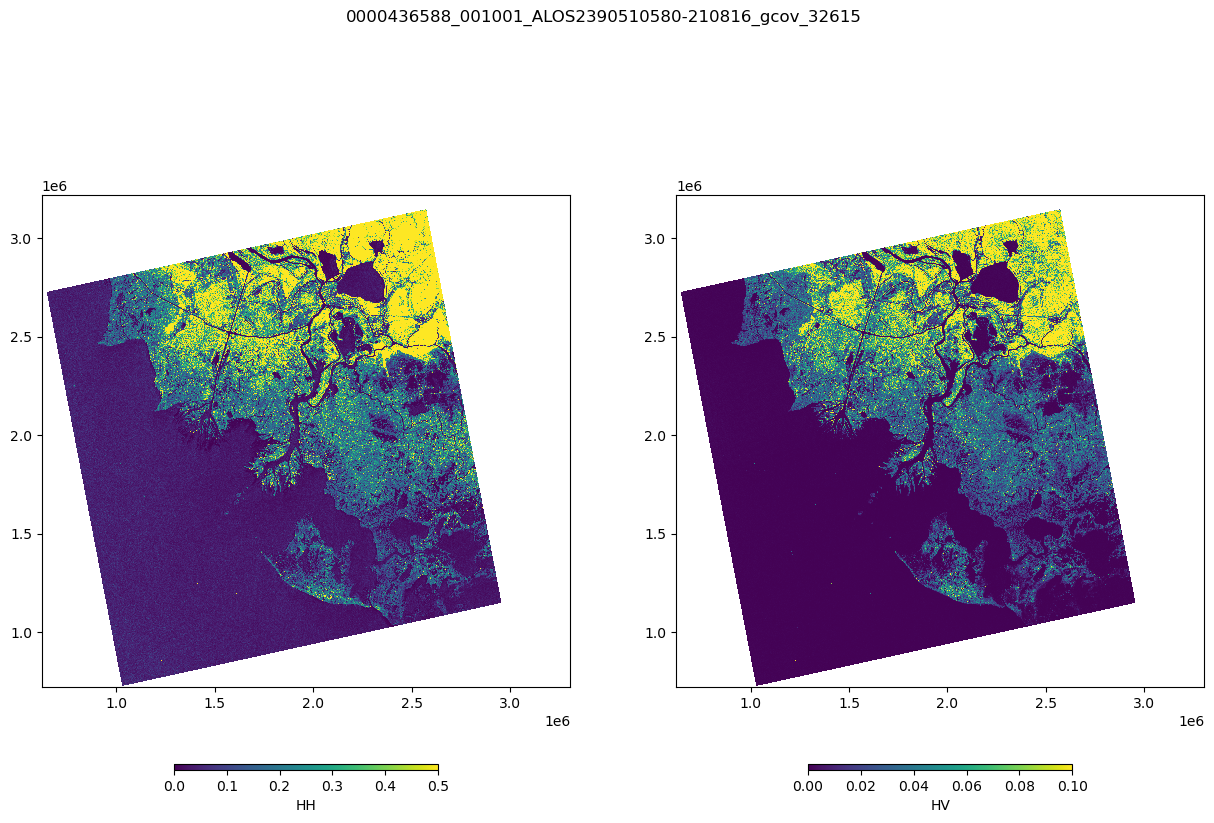

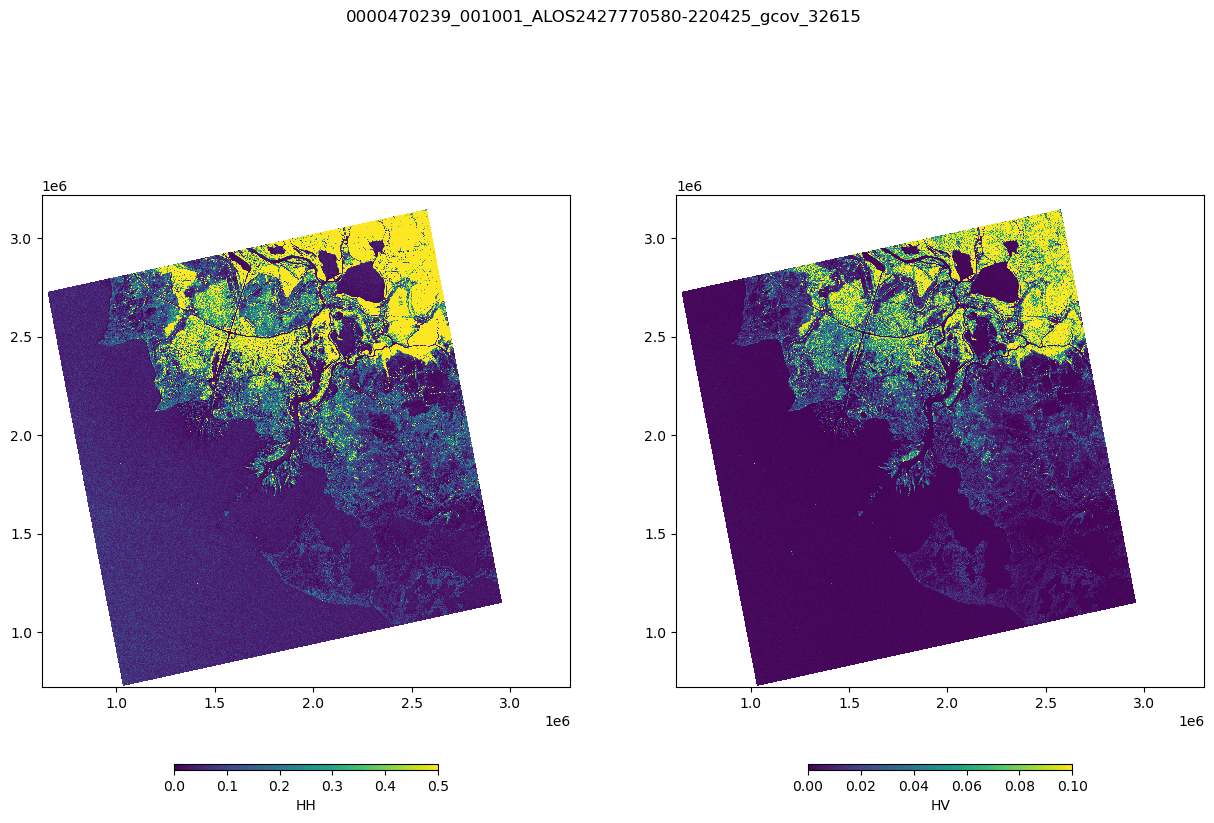

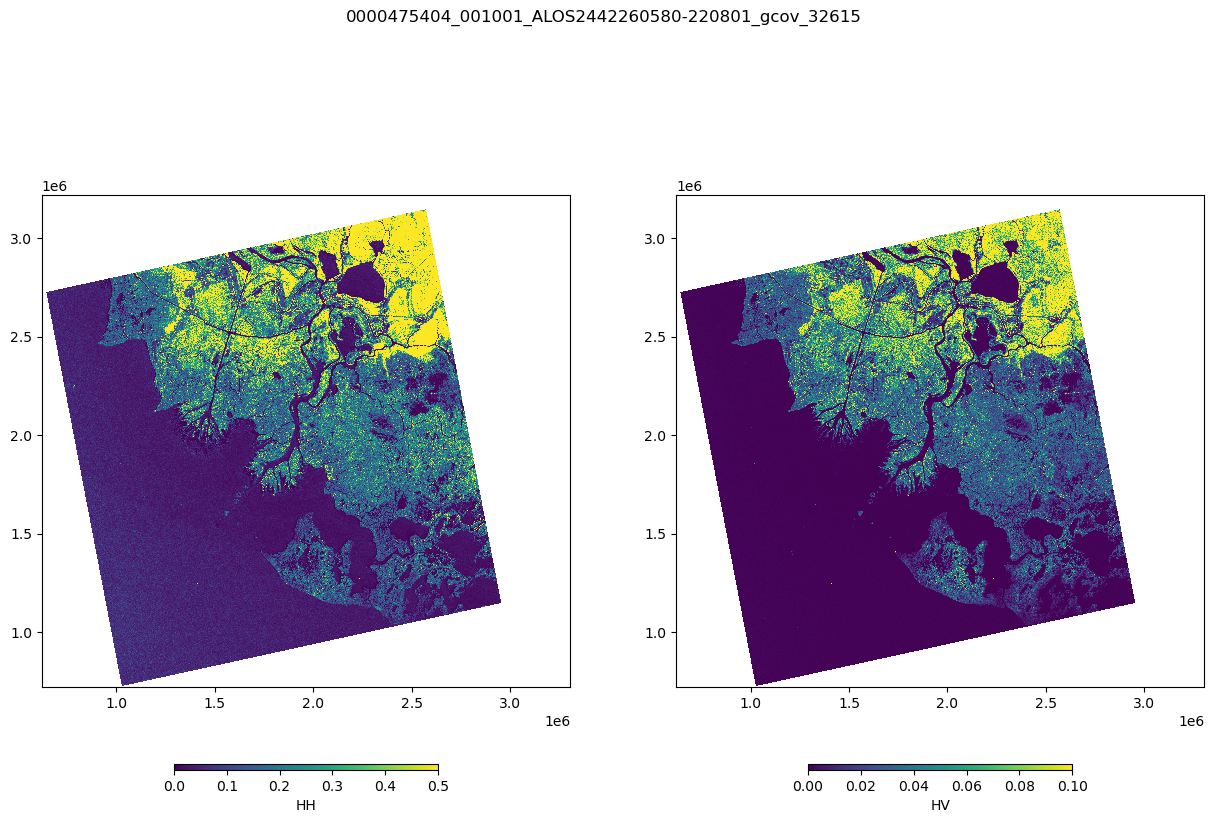

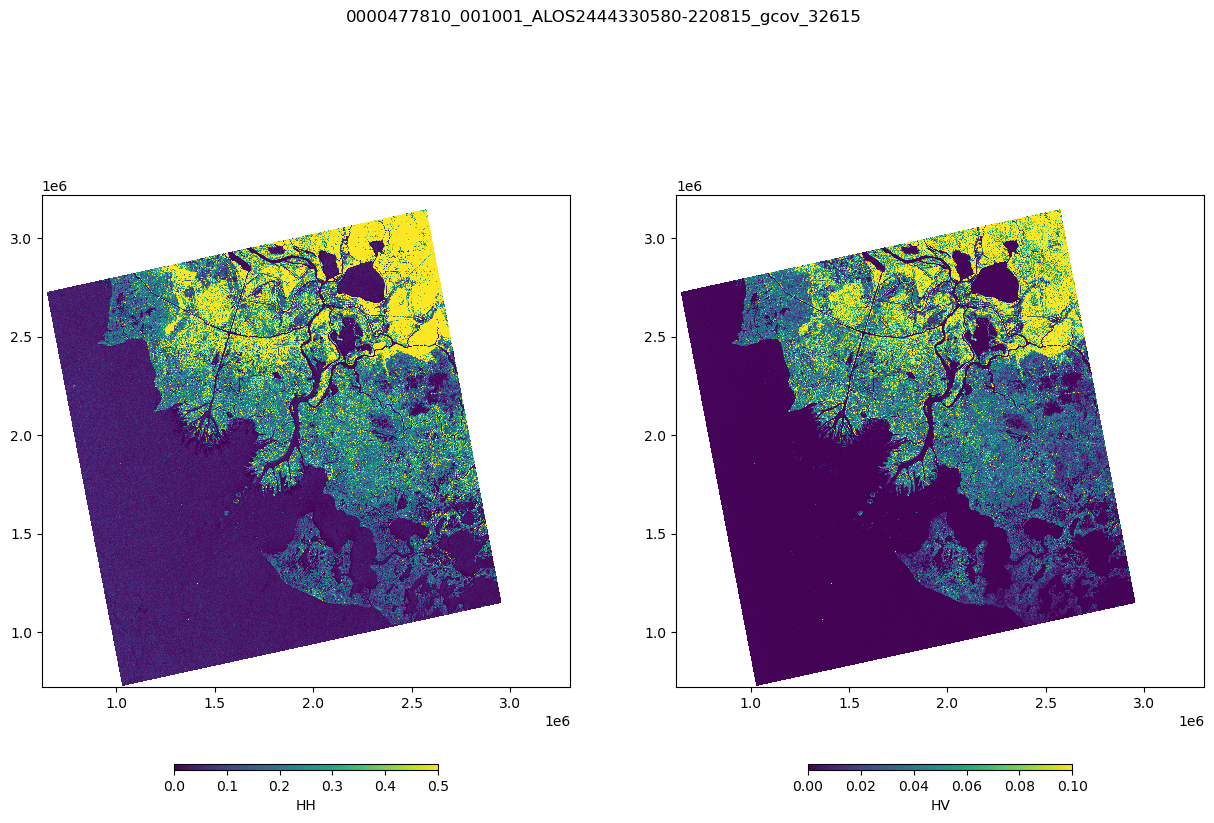

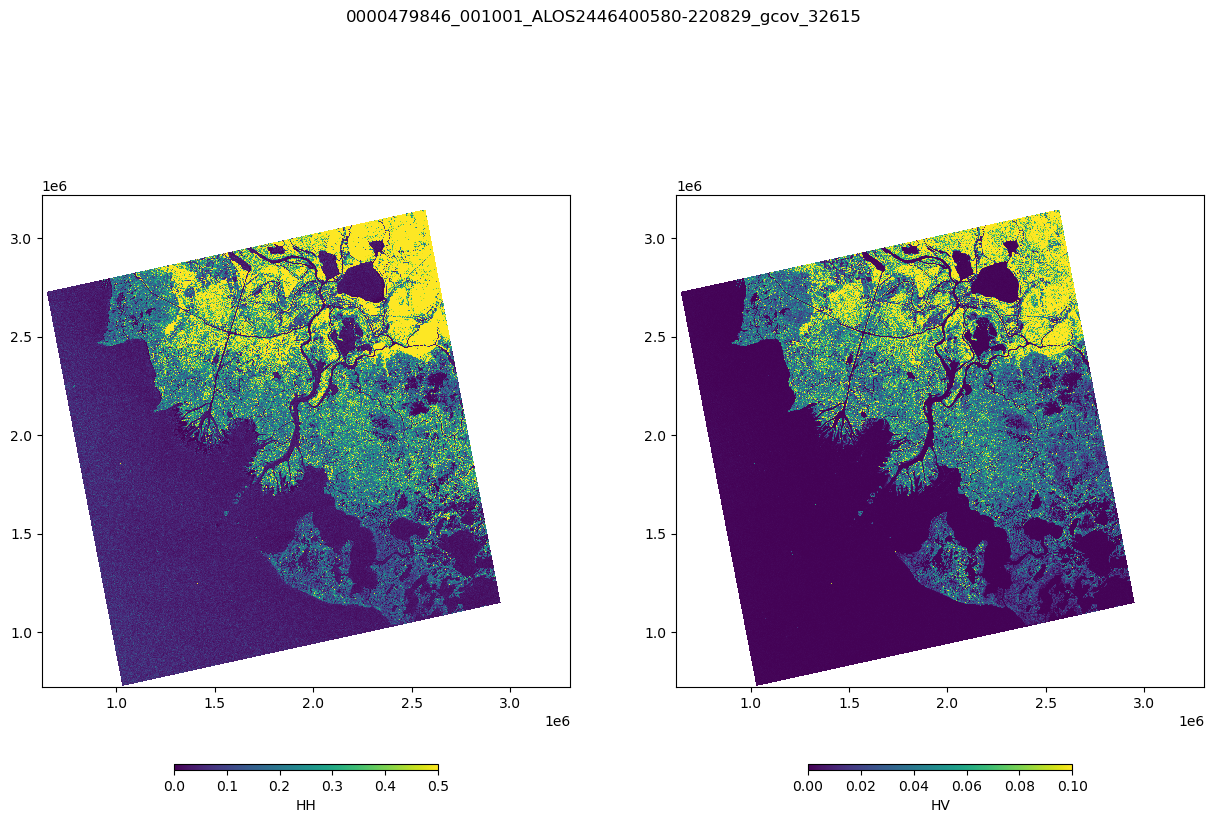

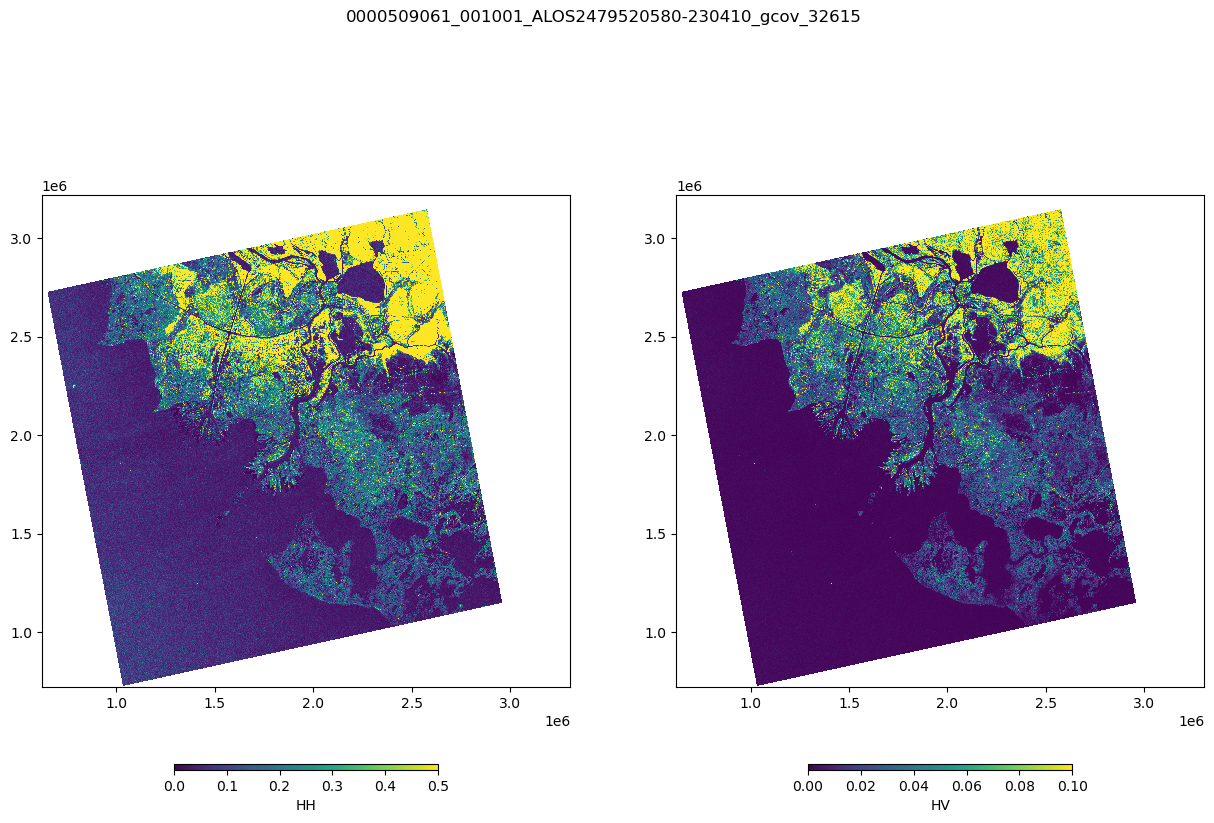

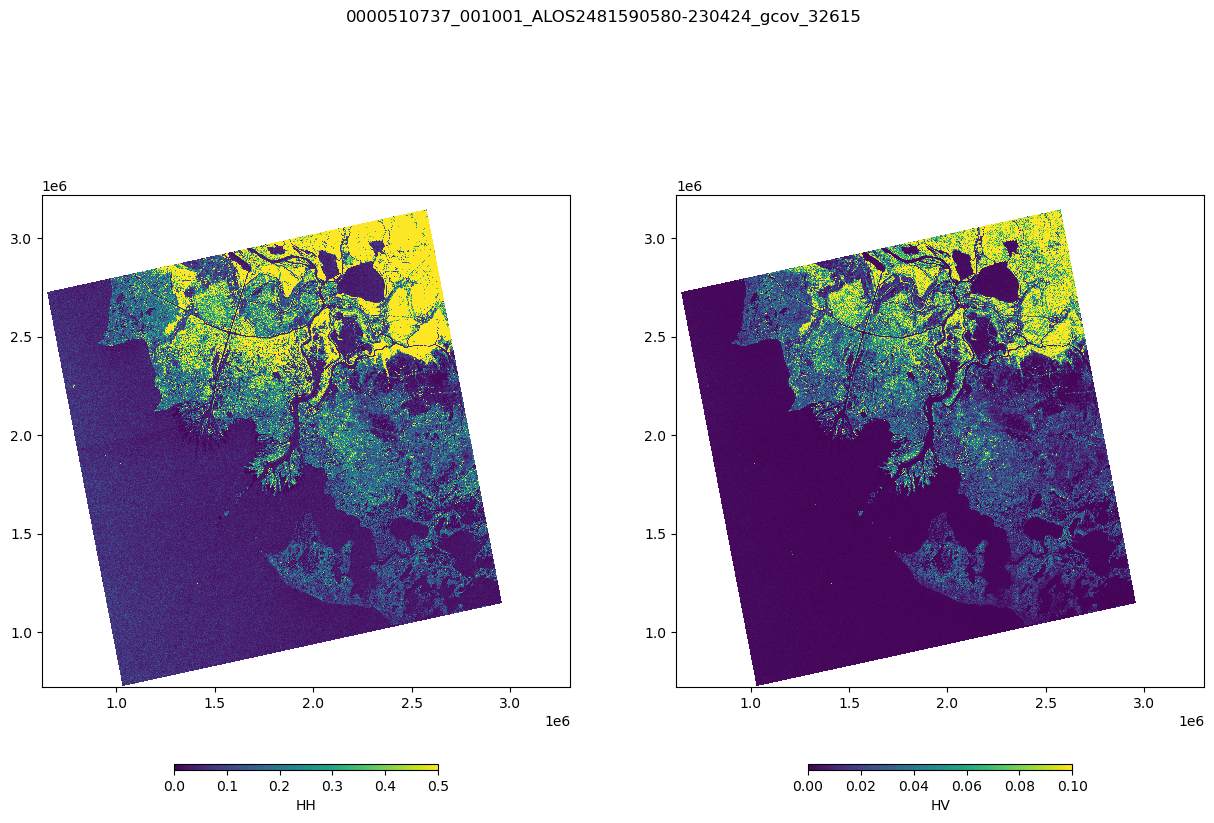

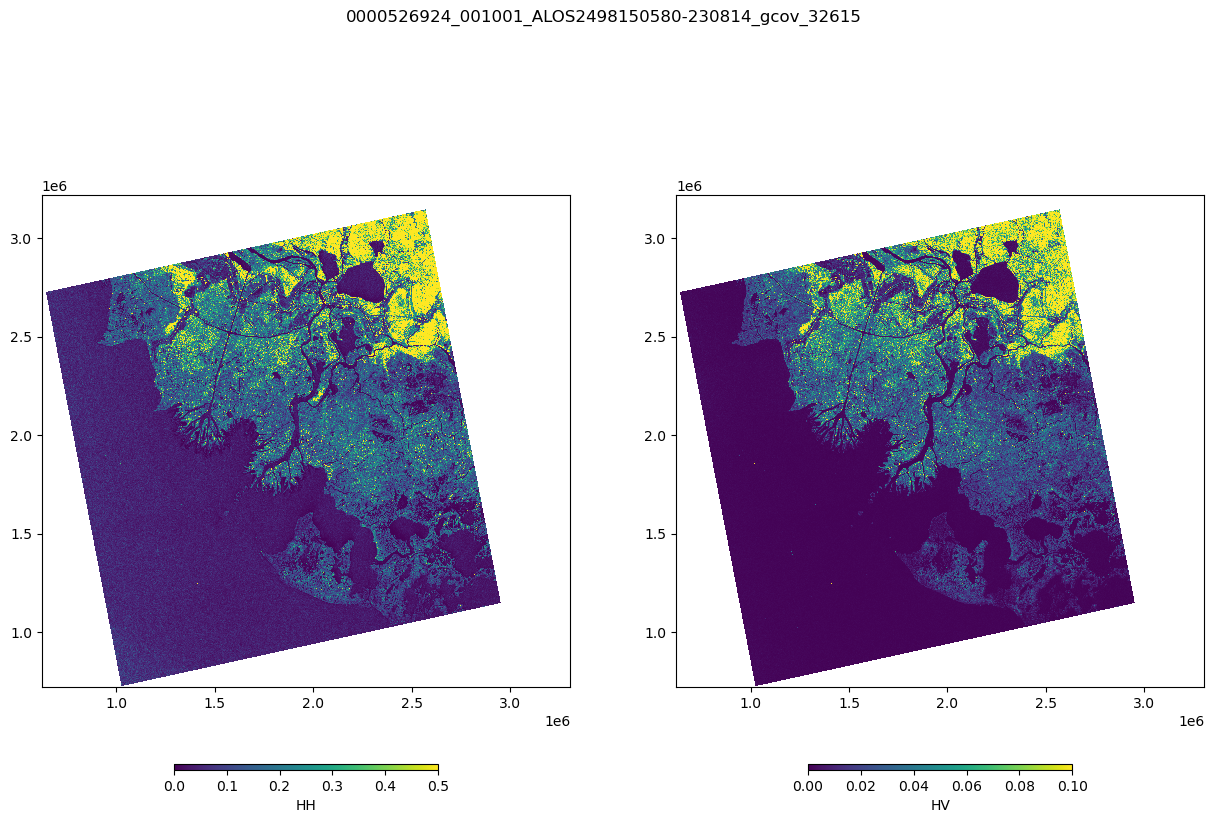

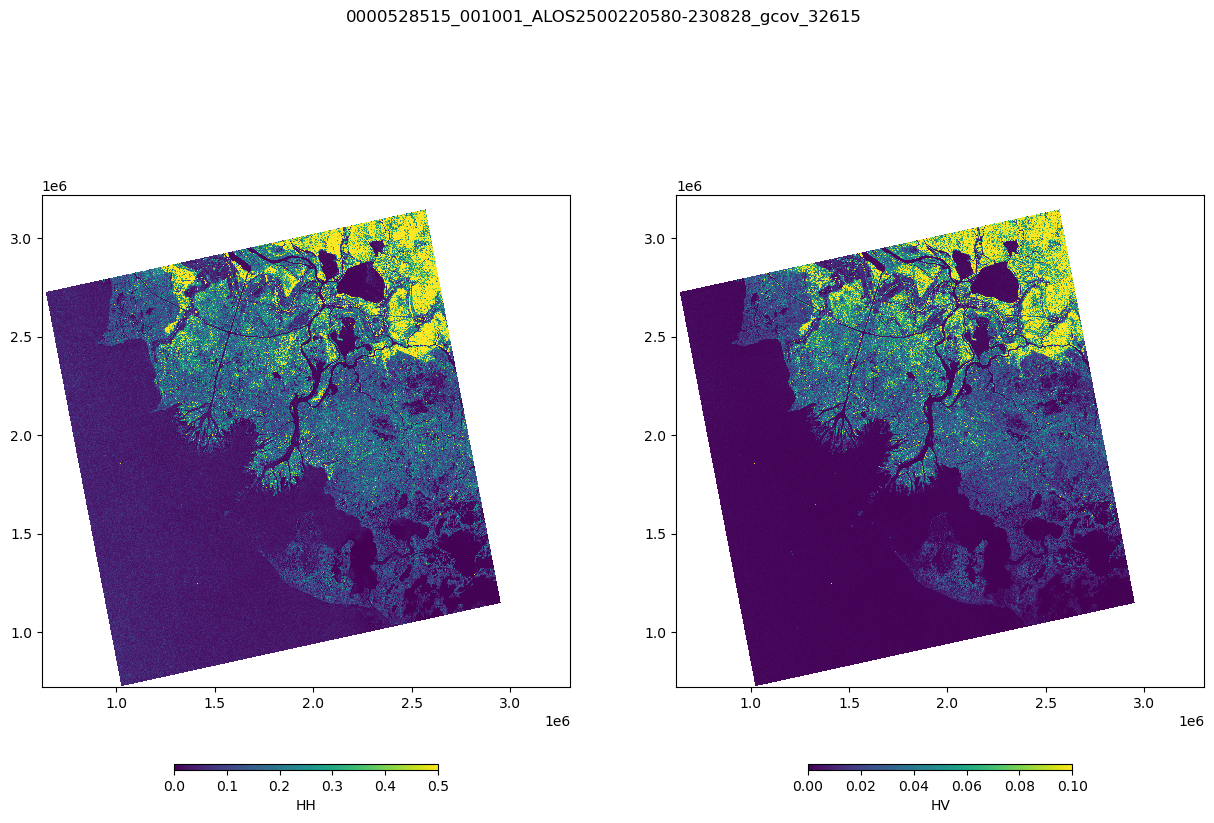

In [63]:

for NISAR_GCOV in NISAR_GCOVs[:]:
    ALOS2_id = NISAR_GCOV.split('/')[-1][:-3]
    print('')
    print(ALOS2_id)
    f = h5py.File(f"{GCOV_dir/ALOS2_id}.h5", "r") 
    a_group_key = list(f.keys())[0]
    ds_x = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['xCoordinates'][()]      # returns as a h5py dataset object
    ds_y = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['yCoordinates'][()]      # returns as a h5py dataset object
    HH = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['HHHH'][()] 
    HV = f[a_group_key]['LSAR']['GCOV']['grids']['frequencyA']['HVHV'][()] 
    print('Width x Height:' , ds_x.shape, ds_y.shape)
    # ulx = x_posting * round(ds_x[0]/x_posting)
    # lrx = x_posting * round(ds_x[-1]/x_posting)
    # uly = y_posting * round(ds_y[0]/y_posting)
    # lry = y_posting * round(ds_y[-1]/y_posting)
    extent= (ds_x[0],ds_y[0],ds_x[-1],ds_y[-1]) 
    print('Top Left: ', ds_x[0],ds_y[0])
    print('Bottom Right: ', ds_x[-1],ds_y[-1])
    
    fig, [ax1,ax2] = plt.subplots(1,2,figsize = (15,10))
    im1 = ax1.imshow(HH, interpolation = 'nearest',
          extent = extent, vmin=0,vmax=0.5,cmap='viridis')
    cbar1 = plt.colorbar(im1, ax=ax1,
            shrink=0.5, orientation='horizontal',
            pad=0.1, aspect=50,label='HH')
    im2 = ax2.imshow(HV, interpolation = 'nearest',
          extent = extent, vmin=0,vmax=0.1,cmap='viridis')
    cbar2 = plt.colorbar(im2, ax=ax2,
            shrink=0.5, orientation='horizontal',
            pad=0.1, aspect=50,label='HV')
    plt.suptitle(ALOS2_id)
    plt.savefig(GCOV_dir/ (ALOS2_id + '_HH-HV.png'))


## Make an animation

In [64]:
all_figs = [os.path.join(dirpath,f)
                for dirpath,dirnames, files in os.walk(GCOV_dir)
                for f in fnmatch.filter(files,'*.png')]
all_figs.sort()
with imageio.get_writer('%s/%s.gif' %(GCOV_dir,aoi_str),mode='I',duration=300) as writer:
    for file in all_figs:
        print(file)
        image = imageio.imread(file)
        writer.append_data(image)
        

/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000436588_001001_ALOS2390510580-210816_gcov_32615_HH-HV.png
/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000470239_001001_ALOS2427770580-220425_gcov_32615_HH-HV.png
/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000475404_001001_ALOS2442260580-220801_gcov_32615_HH-HV.png
/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000477810_001001_ALOS2444330580-220815_gcov_32615_HH-HV.png
/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000479846_001001_ALOS2446400580-220829_gcov_32615_HH-HV.png
/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000509061_001001_ALOS2479520580-230410_gcov_32615_HH-HV.png
/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000510737_001001_ALOS2481590580-230424_gcov_32615_HH-HV.png
/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000526924_001001_ALOS2498150580-230814_gcov_32615_HH-HV.png
/home/jovyan/Wax_Lake_Delta_Louisiana/51/580/GCOV/0000528515_001001_ALOS2500220580-230828_gcov_32615_HH-HV.png


/tmp/ipykernel_41568/1486789389.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file)


## Clean TMP files

In [ ]:
shutil.rmtree(TMP_dir) 
shutil.rmtree(ALOS2_dir)

In [ ]:
## Command line option

######## ALOS2 SLC to NISAR RSLC
# for f in /scratch/alex_eco_test/ALOS2/southfork/*/; 
# do python /home/jovyan/isce3/share/nisar/examples/alos2_to_nisar_l1.py -i $f -o "${f%.*}".h5; 
# done

######## Get NISAR DEM
# for f in /scratch/alex_eco_test/ALOS2/southfork/rslc/*; 
# do python /home/jovyan/isce3/python/packages/nisar/workflows/stage_dem.py -p $f -o "${f%.*}".vrt; 
# done

######## NISAR RSLC to NISAR GCOV
# for f in /scratch/alex_eco_test/ALOS2/southfork/rslc/*.yaml; 
# do python /home/jovyan/isce3/python/packages/nisar/workflows/gcov.py $f; 
# done